In [2]:
# 📦 Kütüphaneler
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, KFold
import joblib

## Train SoH Model

In [3]:
# Veri yükle
df_soh = pd.read_csv("data/processed/battery_data_soh.csv")

In [ ]:
# Özellik ve hedef ayır
# Öznitelik seçimi
X = df_soh[['avg_voltage', 'avg_current', 'max_temperature']]
y = df_soh['soh']

In [ ]:
# Model tanımı
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 10-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = (-mse_scores) ** 0.5

In [ ]:
#Sonuçların yazdırılması
print("📊 10-Fold CV RMSE Ortalaması:", rmse_scores.mean())
print("📉 Fold Bazlı RMSE:", rmse_scores)

📊 10-Fold CV RMSE Ortalaması: 0.012850572152031553
📉 Fold Bazlı RMSE: [0.01827495 0.01210058 0.01712783 0.00715522 0.01384809 0.01807894
 0.00700748 0.0119534  0.01249904 0.0104602 ]


In [ ]:
#Model eğitimi
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
#Sonuçların yazdırılması
print("✅ Final SOH Test Performansı:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

✅ Final SOH Test Performansı:
MSE: 0.00025696479612877737
R²: 0.9792854183811615


## 📊 SOH Model Performans Değerlendirmesi

### 🔟 10-Fold Cross-Validation Sonuçları

- **RMSE Ortalaması:** `0.01285`

Bu değer, modelin 10 farklı veri bölmesinde test edilirken ortalama olarak tahminlerinde yaptığı hata miktarını ifade eder. Düşük bir değer olması, modelin genelleme performansının güçlü olduğunu gösterir.

#### 📉 Fold Bazlı RMSE Değerleri:  
[0.01827, 0.01210, 0.01713, 0.00716, 0.01385, 0.01808, 0.00701, 0.01195, 0.01250, 0.01046]


Bu değerlerin genel olarak düşük ve birbirine yakın olması, modelin istikrarlı olduğunu ve farklı veri bölmelerinde benzer başarı sağladığını gösterir.

---

### ✅ Final Test Performansı

- **MSE (Mean Squared Error):** `0.00026`
- **R² (Determination Coefficient):** `0.9793`

🔹 MSE değeri oldukça düşük, bu da modelin test verilerinde çok küçük hatalarla tahmin yaptığını gösterir.

🔹 R² değeri 1'e çok yakın (`0.9793`), bu da modelin verideki varyansın %97.9’unu doğru şekilde açıkladığını gösterir. Yani, model veriye oldukça iyi uyum sağlamıştır.

---

### 📌 Genel Yorum

Model, hem çapraz doğrulamada hem de ayrı test setinde düşük hata ve yüksek doğruluk ile başarılı bir performans sergilemiştir. Eğitim süreci sırasında overfitting yaşanmadığı ve modelin genelleme yeteneğinin yüksek olduğu söylenebilir.


In [13]:
# Kaydet
joblib.dump(rf_model, "models/soh_model.pkl")
print("📁 SOH modeli kaydedildi: models/soh_model.pkl")

📁 SOH modeli kaydedildi: models/soh_model.pkl


## Train SoC Model

In [14]:
# SOC verisini oku
df_soc = pd.read_csv("data/processed/battery_data_soc.csv")

In [ ]:
# Önemli değişkenleri seç
features = ['voltage', 'current', 'temperature']
target = 'soc'
window_size = 50    # Her örnekte 50 zaman adımı olacak

In [16]:
def create_sequences(data, features, target, window_size):
    sequences = []
    labels = []

    for cycle_id in data['cycle'].unique():
        cycle_data = data[data['cycle'] == cycle_id].sort_values(by='time')
        if len(cycle_data) < window_size + 1:
            continue

        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(cycle_data[features])

        target_series = cycle_data[target].values

        for i in range(len(scaled_features) - window_size):
            seq = scaled_features[i:i + window_size]
            label = target_series[i + window_size]
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

In [ ]:
# Veri sızıntısını önlemek için cycle bazlı bölme
cycle_ids = df_soc['cycle'].unique()
np.random.seed(42)
np.random.shuffle(cycle_ids)
split_idx = int(len(cycle_ids) * 0.8)
train_cycles = cycle_ids[:split_idx]
test_cycles = cycle_ids[split_idx:]

train_data = df_soc[df_soc['cycle'].isin(train_cycles)]
test_data = df_soc[df_soc['cycle'].isin(test_cycles)]

X_train, y_train = create_sequences(train_data, features, target, window_size)
X_test, y_test = create_sequences(test_data, features, target, window_size)


In [ ]:
# LSTM Modeli
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
# Model eğitimi
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0172 - mae: 0.0812 - val_loss: 0.0027 - val_mae: 0.0395
Epoch 2/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0026 - val_mae: 0.0428
Epoch 3/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0028 - val_mae: 0.0429
Epoch 4/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0030 - val_mae: 0.0365
Epoch 5/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 0.0024 - val_mae: 0.0319
Epoch 6/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0297
Epoch 7/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0315
Epoch 8/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 0.0028 - val_mae: 0.0331
Epoch 9/20
1237/1237 ━━━

In [27]:
# Değerlendirme
loss, mae = lstm_model.evaluate(X_test, y_test)
print("✅ SOC Model Performansı:")
print("Test MAE:", mae)

737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0014 - mae: 0.0277
✅ SOC Model Performansı:
Test MAE: 0.027747701853513718


### ✅ SOC Modeli Test Performansı Değerlendirmesi
#### 🔢 Test MAE (Mean Absolute Error): 0.0277

Bu değer, modelin ortalama olarak tahmin ettiği SOC değerlerinin gerçek değerlere yaklaşık %2.77'lik bir mutlak sapma ile yaklaştığını gösterir. Bu oldukça düşük bir hata oranı olup modelin yüksek doğrulukla çalıştığını ortaya koyar.

MAE değeri küçük olduğunda, model tahminleri gerçek değerlere daha yakındır.


737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


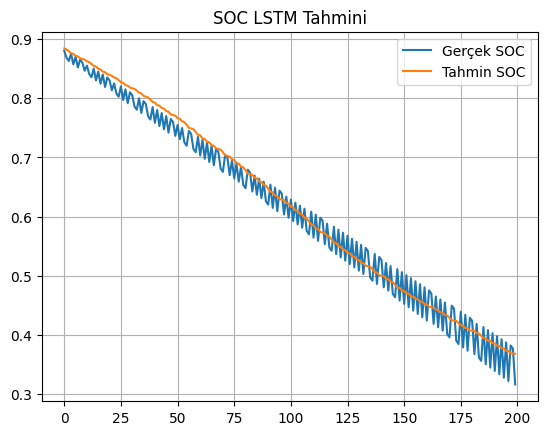

In [28]:
# Tahmin grafiği
y_pred = lstm_model.predict(X_test)
plt.plot(y_test[:200], label='Gerçek SOC')
plt.plot(y_pred[:200], label='Tahmin SOC')
plt.legend()
plt.title("SOC LSTM Tahmini")
plt.grid(True)
plt.show()

In [29]:
# Kaydet
lstm_model.save("models/soc_model.h5")
print("📁 SOC modeli kaydedildi: models/soc_model.h5")

📁 SOC modeli kaydedildi: models/soc_model.h5
